In [1]:
import pandas as pd
import numpy as np


from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from Machine_Learning_Tools.plots import *
from imblearn.combine import SMOTEENN
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook',style='whitegrid',palette='nipy_spectral',font_scale=1.5)
%matplotlib inline

In [2]:
df = pd.read_csv('datasets/bank-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Attribute Information:

- age (numeric)
- job : type of job (categorical:admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical:'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- balance: average yearly balance, in euros (numeric)
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- contact: contact communication type (categorical:'cellular','telephone')
- day: last contact day of the month (numeric 1 -31)
- month: last contact month of year (categorical: 'jan', 'feb','mar', …, 'nov', 'dec')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., ifduration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign(categorical: 'failure','nonexistent','success')
- target: has the client subscribed a term deposit? (binary:"yes","no")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
numeric_features = list(df.describe().columns)
cat_features = list(df.drop(numeric_features,axis=1).columns)

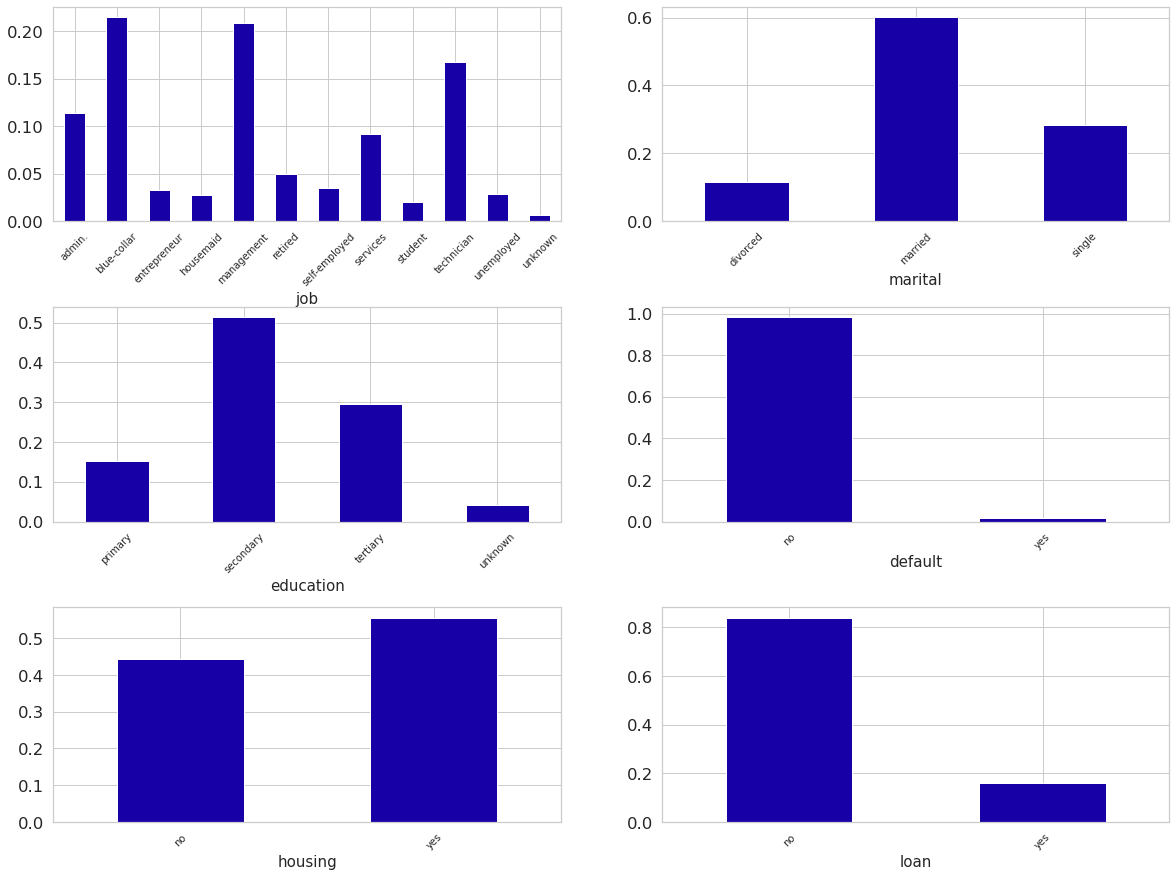

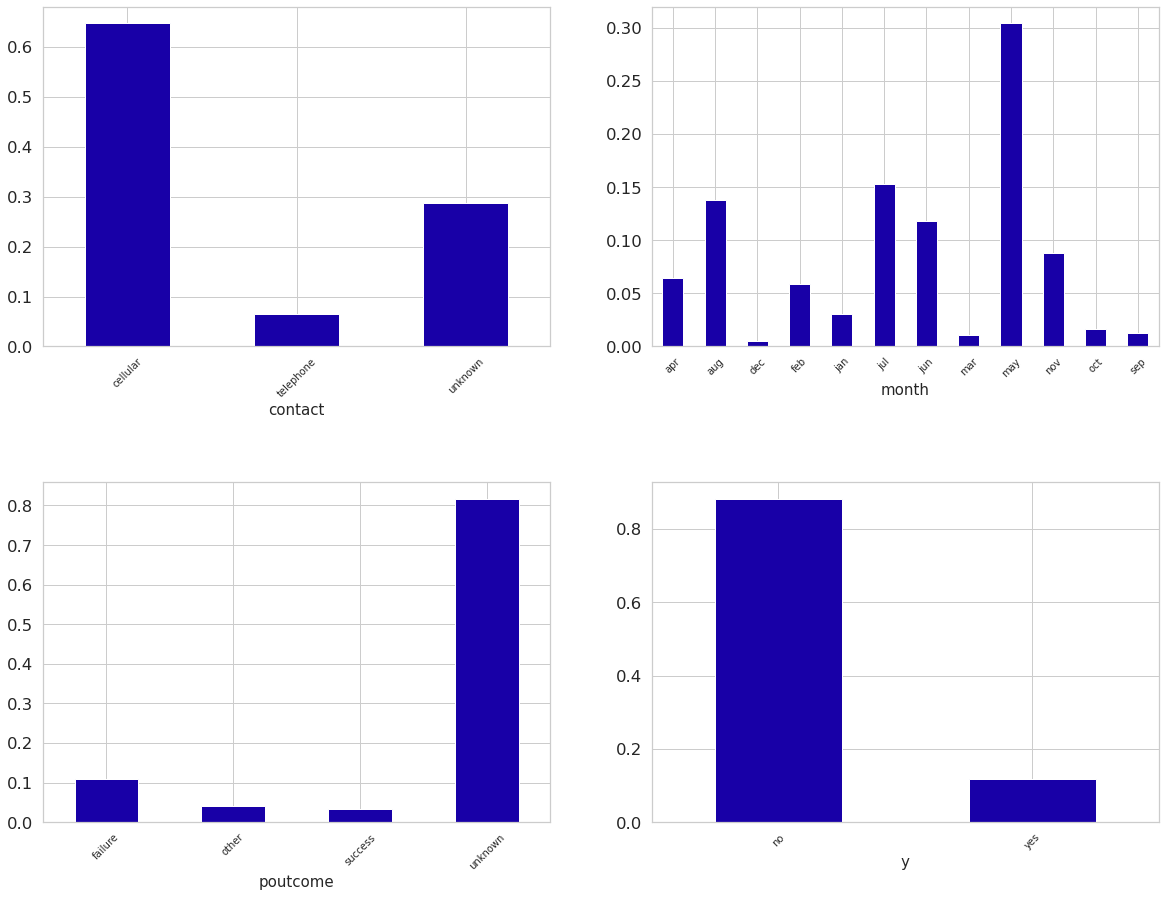

In [20]:
barplot1(df,cat_features[:6],rows=3,cols=2,figsize=(20,15),xticks_size=10)
barplot1(df,cat_features[6:],rows=2,cols=2,figsize=(20,15),xticks_size=10)

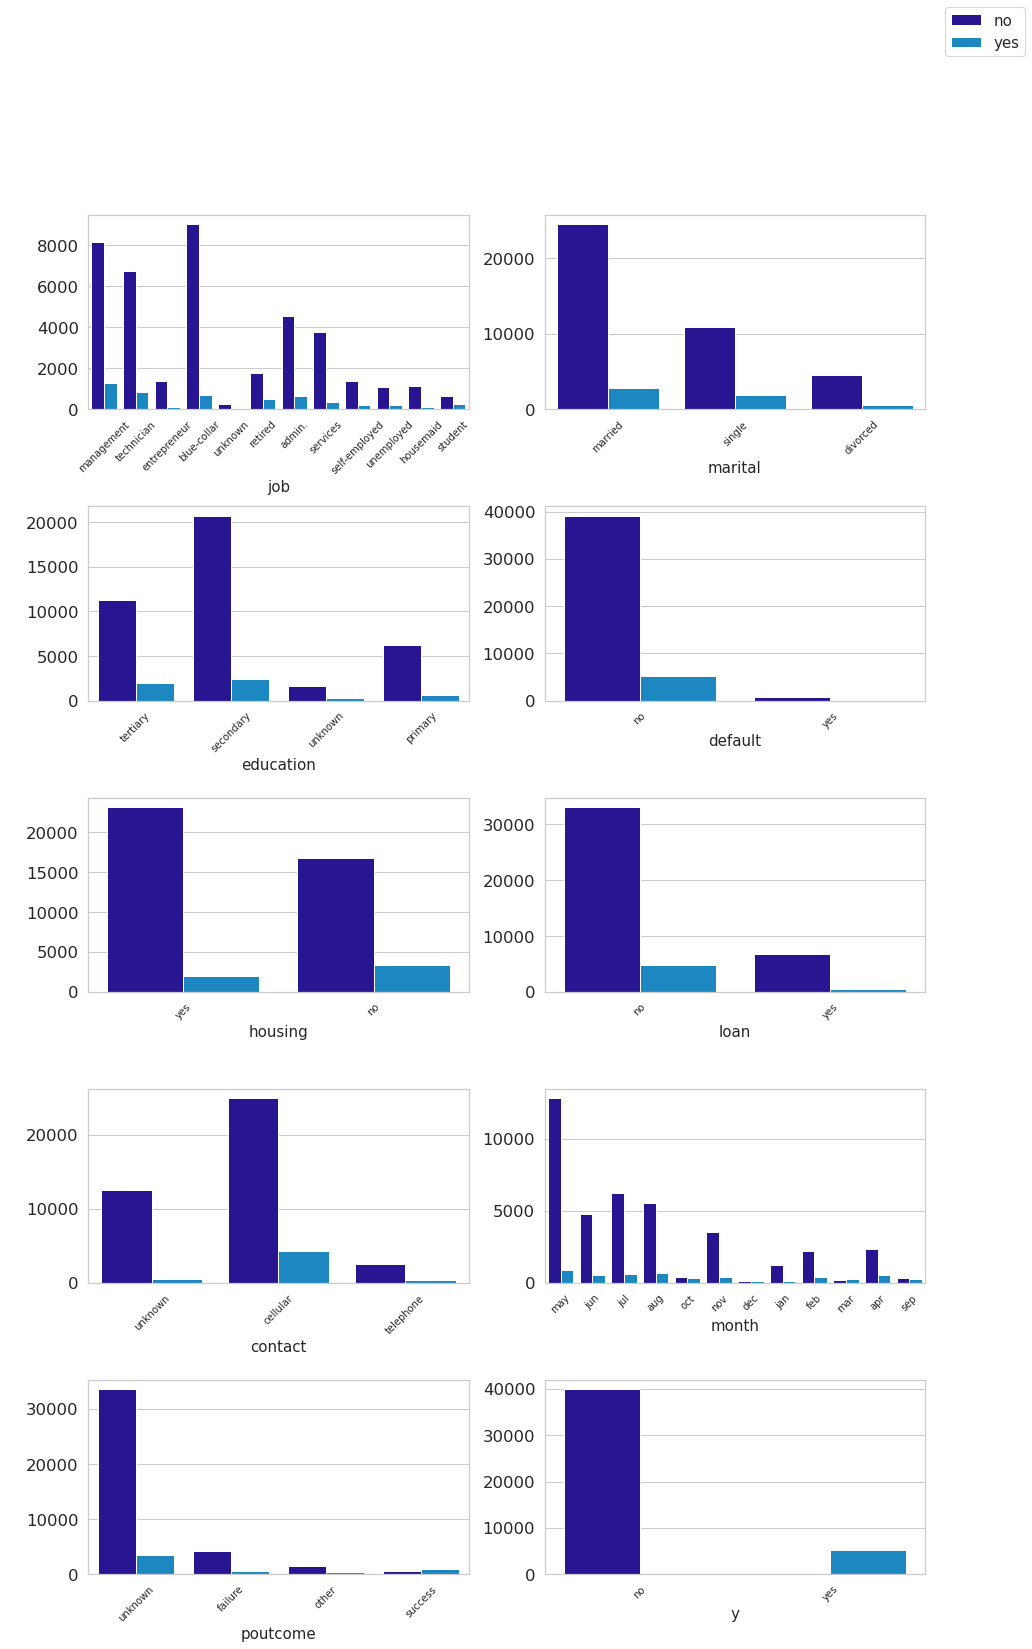

In [24]:
barplot2(df,cat_features,rows=5,cols=2,figsize=(15,25),hue='y',hspace=0.5)

In [26]:
sns.boxplot(data=df,x=)

Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A 